# Using generalized tracers and power spectra
This example showcases how to use the generalized tracers and 2D power spectra implemented in CCL

In [1]:
import numpy as np
import pylab as plt
import pyccl as ccl
%matplotlib inline

## Preliminaries
Let's just begin by setting up a cosmology and a couple of redshift distributions and bias functions

In [2]:
# Cosmology
cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, A_s=2.1e-9, n_s=0.96)

# Redshift-dependent functions
z = np.linspace(0,1.2,1024)
# Redshift distributions
nz1 = np.exp(-((z-0.5)/0.05)**2/2)
nz2 = np.exp(-((z-0.65)/0.05)**2/2)
# Bias
bz = 0.95/ccl.growth_factor(cosmo,1./(1+z))
# Magnification bias
sz = np.ones_like(z)
# Intrinsic alignment amplitude
az = -0.004 * np.ones_like(z)

## Standard tracers
There are a set of standard tracers with built-in constructors.
First, there is number counts tracers (a.k.a. galaxy clustering). These include the standard contribution from the matter overdensity multiplied by a linear, scale-independent bias, redshift-space distortions and magnification. You can turn off any of them.

In [3]:
# This tracer will only include the density contribution
gc_d = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z,nz1), bias=(z,bz), mag_bias=None)
# If you pass bias=None, then the tracer will not have a density term. E.g. this one is an RSD-only tracer.
gc_r = ccl.NumberCountsTracer(cosmo, has_rsd=True, dndz=(z,nz1), bias=None, mag_bias=None)
# Now a magnification-only tracer. To turn on magnification just pass a non-None mag_bias.
gc_m = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z,nz1), bias=None, mag_bias=(z,sz))
# You can of course create a tracer that includes all of these terms
gc_a = ccl.NumberCountsTracer(cosmo, has_rsd=True, dndz=(z,nz1), bias=(z,bz), mag_bias=(z,sz))

There are also standard weak lensing tracers with two terms: the cosmic shear term due to lensing and intrinsic alignments within the L-NLA model with a scale-independent IA amplitude.

In [4]:
# This tracer will only include the lensing shear contribution (by setting the ia_bias to None)
wl_s = ccl.WeakLensingTracer(cosmo, dndz=(z,nz2), has_shear=True, ia_bias=None)
# This tracer will only include IAs
wl_i = ccl.WeakLensingTracer(cosmo, dndz=(z,nz2), has_shear=False, ia_bias=(z,az))
# And you can have the full monty
wl_a = ccl.WeakLensingTracer(cosmo, dndz=(z,nz2), has_shear=True, ia_bias=(z,az))

Finally, we also have CMB lensing tracers, defined by a single source redshift.

In [5]:
# We put the source at z=1100, but you can put it at any other redshift if you want to!
# It won't be CMB lensing though.
cmbl = ccl.CMBLensingTracer(cosmo, z_source=1100.)

## Custom tracers

In general, tracers are things you can cross-correlate and get a power spectrum from. In the most general case, the angular power spectrum between two tracers is given by

\begin{equation}
   C^{\alpha\beta}_\ell=\frac{2}{\pi}\int d\chi_1\,d\chi_2\,dk\,k^2 P_{\alpha\beta}(k,\chi_1,\chi_2)\,\Delta^\alpha_\ell(k,\chi_1)\,\Delta^\beta_\ell(k,\chi_2).
\end{equation},

where $P_{\alpha\beta}$ is a generalized power spectrum (see below), and $\Delta^\alpha_\ell(k,\chi)$ is a sum over different contributions associated to tracer $\alpha$, where every contribution takes the form:
\begin{equation}
  \Delta^\alpha_\ell(k,\chi)=f^\alpha_\ell\,W_\alpha(\chi)\,T_\alpha(k,\chi)\,j^{(n_\alpha)}_\ell(k\chi).
\end{equation}

Here, $f^\alpha_\ell$ is an **$\ell$-dependent prefactor**, usually associated with angular derivatives, $W_\alpha(\chi)$ is the **radial kernel**, dependent only on redshift/distance, $T_\alpha(k,\chi)$ is the **transfer function**, dependent on both $k$ and $z/\chi$, and $j^{(n)}_\ell(x)$ is a generalized versions of the **spherical Bessel functions**, associated with radial derivatives or inverse Laplacians.

Generalized tracers can be created as instances of the `Tracer` class. This is done in two steps:
  1. First, generate an empty tracer:
  2. Then, add a contribution to this tracer. A contribution is defined by the 4 parameters above:
   - The **$\ell$-dependent prefactor** is defined by the argument `der_angles`. This can be 0, 1 or 2. 0 means no prefactor, 1 means a prefactor $\ell(\ell+1)$ and 2 means a prefactor $\sqrt{(\ell+2)!/(\ell-2)!}$.
   - The form of the **spherical Bessel function** is determined by the argument `der_bessel`, which can be -1, 0, 1 or 2. For 0, 1 or 2, this determines the derivative of the Bessel function that this contribution uses. For `der_bessel=-1`, $j^{(-1)}_\ell(x)=j_\ell(x)/x$.
   - The **radial kernel** is determined by two arrays corresponding to $\chi$ and $W(\chi)$, wrapped into a tuple and passed as `kernel`. If `kernel=None`, CCL assumes that the radial kernel is 1 everywhere for this tracer.
   - The **transfer function** can be passed in two different forms. If your transfer function is factorizable, then use two parameters: `transfer_k` and `transfer_a`, corresponding to the $k$-dependent and redshift-dependent factors respectively. `transfer_k` should be a tuple of two arrays $(\ln(k),K(k))$, and `transfer_a` should be $(a,A(a))$, where $a$ is the scale factor (which should be monotonically increasing!). The total transfer function is then given by $T(a,k)=K(k) A(a)$. If your transfer function is not factorizable, then use the argument `transfer_ka`. This should be a tuple of three arrays $(a,\ln(k),T(a,k))$, where $a$ is an array of scale factors in ascending order, $\ln(k)$ is an array containing the logarithms of wavenumbers, and $T(a,k)$ is a 2D array containing the values of the transfer function at the corresponding values of $a$ and $k$. If $a$ and $\ln(k)$ have sizes $n_a$ and $n_k$ respectively, then $T(a,k)$ should have shape $(n_a,n_k)$. If `transfer_ka`, `transfer_a` or `transfer_k` are `None`, CCL assumes that the corresponding quantities are 1 everywhere.

Then, keep adding contributions until you're done.

Let's try this out by building a number-counts tracer that contains a linear bias, RSDs and magnification. We could do this easily with the built-in constructors above, but it's always satisfying when you build something with your own hands.

In [6]:
# First, initialize empty tracer
gc_custom = ccl.Tracer()

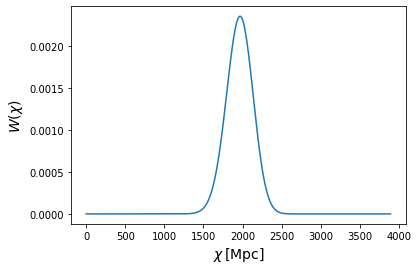

In [7]:
# Now we need to generate a radial kernel and a transfer function.
# To generate the radial kernel we can use a convenience function that exists in CCL:
kernel = ccl.get_density_kernel(cosmo, (z,nz1))
# Let's plot it out of curiosity:
plt.plot(kernel[0],kernel[1])
plt.xlabel('$\\chi\\,[{\\rm Mpc}]$',fontsize=14)
plt.ylabel('$W(\\chi)$',fontsize=14)
plt.show()

In [8]:
# We also need a transfer function.
# Because this tracer has a simple linear bias, the transfer function
# is only z-dependent and not k-dependent. So it's factorizable.
# The scale factor values need to be increasing, so we'll reverse
# The order of all arrays:
sf = (1./(1+z))[::-1]
transfer_a = (sf,bz[::-1])

In [9]:
# Now we're ready to add the density contribution to the tracer:
gc_custom.add_tracer(cosmo, kernel=kernel, transfer_a=transfer_a)

In [10]:
# Now let's add RSDs.
# In this case the transfer function is just given by the growth rate.
# Also, RSDs use the second derivative of the Bessel function
transfer_a_rsd = (sf, -ccl.growth_rate(cosmo,sf))
gc_custom.add_tracer(cosmo, kernel=kernel, transfer_a=transfer_a_rsd, der_bessel=2)

In [11]:
# And now magnification.
# Again, there is a built-in function to compute the radial kernel for
# lensing observables.
# For magnification, der_bessel=-1 and der_angles=1.
# The transfer function is just 1 everywhere
chis, w = ccl.get_lensing_kernel(cosmo, (z,nz1), mag_bias=(z,sz))
kernel_m = (chis, -2*w)
gc_custom.add_tracer(cosmo, kernel=kernel_m, der_bessel=-1, der_angles=1)

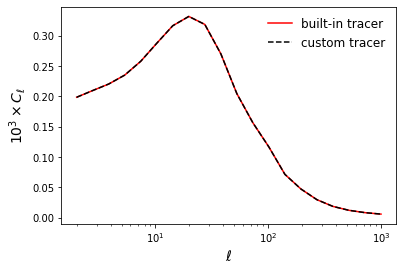

In [12]:
# Now let's check that both tracers, the one we just
# created and the original one created using the built-in constructors
# give exactly the same result. To do that, let's compute their
# angular power spectra
ells = np.geomspace(2,1000,20)
cl_gc_a = ccl.angular_cl(cosmo, gc_a, gc_a, ells)
cl_gc_custom = ccl.angular_cl(cosmo, gc_custom, gc_custom, ells)

# Let's plot the result
plt.plot(ells, 1E4*cl_gc_a, 'r-', label='built-in tracer')
plt.plot(ells, 1E4*cl_gc_custom, 'k--', label='custom tracer')
plt.xscale('log')
plt.xlabel('$\\ell$', fontsize=14)
plt.ylabel('$10^3\\times C_\\ell$', fontsize=14)
plt.legend(loc='upper right', fontsize=12, frameon=False)
plt.show()

OK, but so far we haven't done anything that we couldn't have done with the built-in tracers. Let's have some fun!

How about adding a contribution to the custom tracer corresponding to the effect of non-Gaussianity. Non-Gaussianity generates a scale-dependent bias on biased tracers that becomes relevant on large scales. Using Eq. 9 of arXiv:0710.4560, the bias receives an additive term of the form:
\begin{equation}
 \Delta b = (b-1)f_{\rm NL}\frac{3\,\delta_c\,\Omega_M\,H_0^2}{D(a)\,k^2}.
\end{equation}
So we can include this effect as an additional contribution to the custom tracer that looks like a standard galaxy clustering term with this extra bias. Since the corresponding transfer function is still factorizable, this should be pretty easy:

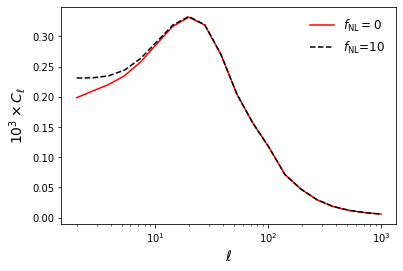

In [13]:
# Let's create an array of k values and the corresponding
# k-dependent part of the transfer function
# 
#  make sure you have camb instelled using pip. Anaconda may install an older version.
#
ks = np.logspace(-5,2,512)
transfer_k_fnl = (np.log(ks),1./ks**2)

# Now the z-dependent part of the transfer function
fNL = 10
delta_c = 1.686
H0 = (cosmo.cosmo.params.h/ccl.physical_constants.CLIGHT_HMPC)
Omega_M = cosmo.cosmo.params.Omega_c+cosmo.cosmo.params.Omega_b
transfer_a_fnl = (sf, (bz[::-1]-1)*3*fNL*delta_c*Omega_M*H0**2/ccl.growth_factor(cosmo,sf))

# Now let's add that contribution
gc_custom.add_tracer(cosmo, kernel=kernel, transfer_a=transfer_a_fnl,
                     transfer_k=transfer_k_fnl)

# And let's check the effect in the power spectrum:
cl_gc_custom_fnl = ccl.angular_cl(cosmo, gc_custom, gc_custom, ells)

# Let's plot the result
plt.plot(ells, 1E4*cl_gc_custom, 'r-', label='$f_{\\rm NL}=0$')
plt.plot(ells, 1E4*cl_gc_custom_fnl, 'k--', label='$f_{\\rm NL}$=%d'%(int(fNL)))
plt.xscale('log')
plt.xlabel('$\\ell$', fontsize=14)
plt.ylabel('$10^3\\times C_\\ell$', fontsize=14)
plt.legend(loc='upper right', fontsize=12, frameon=False)
plt.show()

## Generalized power spectra

By default, when you call `ccl.angular_cl`, CCL will use the non-linear matter power spectrum in the equation for $C_\ell$ above to compute the angular power spectrum. You can however, pass a more general `Pk2D` object. These objects encapsulate generic power spectra that depend simultaneously on $k$ and $a$. They are versatile and can be created in different ways, but for our purposes here, we will generate them in the same way that we generated the tracer transfer functions (i.e. through arrays of scale factors and wavenumbers). For more information, check out the documentation for this class.

To illustrate the use of `Pk2D` objects, let's read off the matter power spectrum from CCL, include a high-$k$ Gaussian cutoff, and generate a `Pk2D` object from that.

In [14]:
# OK, let's first read off the matter power spectrum:
lpk_array = np.log(np.array([ccl.nonlin_matter_power(cosmo,ks,a) for a in sf]))

# Now let's impose a cutoff at a scale k_cut corresponding to roughly ~10 Mpc
k_cut = 0.4
lpk_array -= (ks/k_cut)**2

# Create a Pk2D object
pk_cut = ccl.Pk2D(a_arr=sf, lk_arr=np.log(ks), pk_arr=lpk_array, is_logp=True)


OK, now let's check out the impact of the cutoff on the angular power spectrum.

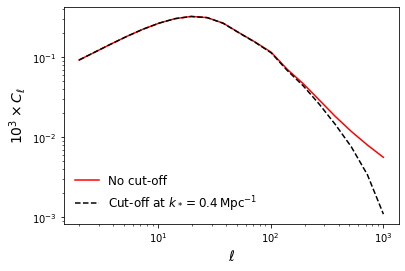

In [15]:
# Compute power spectra with and without cutoff
cl_gc_ncut = ccl.angular_cl(cosmo, gc_d, gc_d, ells)
cl_gc_ycut = ccl.angular_cl(cosmo, gc_d, gc_d, ells, p_of_k_a=pk_cut)

# Plot stuff
plt.plot(ells, 1E4*cl_gc_ncut, 'r-', label='No cut-off')
plt.plot(ells, 1E4*cl_gc_ycut, 'k--', label='Cut-off at $k_* = %.1lf\,{\\rm Mpc}^{-1}$'%(k_cut))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\\ell$', fontsize=14)
plt.ylabel('$10^3\\times C_\\ell$', fontsize=14)
plt.legend(loc='lower left', fontsize=12, frameon=False)
plt.show()